In [166]:
# one needs to import those packages which are needed; best to be done at the beginning of the program.
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import pandas as pd
import scipy as sp
import scipy.sparse as ss
import random as rn
from heapq import nlargest
from collections import Counter
from itertools import combinations

# some basic settings for plotting figures
import matplotlib.pyplot as plt
%matplotlib inline 
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 32}

plt.rc('font', **font)
import numpy.linalg as LA
from sklearn.cluster import KMeans

In [167]:
G0 = nx.read_weighted_edgelist("4932.protein.links.v11.5.txt",comments="#",nodetype=str)

In [168]:
threshold_score = 700
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])

In [169]:
# some basic information
print('number of nodes of G0:',G0.number_of_nodes())
print('number of edges of G0:',G0.number_of_edges())
print('Is the full G0 connected?',nx.connected.is_connected(G0))
print('How many connected subgraphs are there?',nx.connected.number_connected_components(G0))

number of nodes of G0: 6394
number of edges of G0: 120009
Is the full G0 connected? False
How many connected subgraphs are there? 441


In [170]:
#get the largest component
largest_cc = max(nx.connected_components(G0),key=len)
G = G0.subgraph(largest_cc)
print('Type',type(largest_cc))
print('number of nodes of largest connected subgraph of G:',G.number_of_nodes())
print('number of edges of largest connected subgraph of G0:',G.number_of_edges())

Type <class 'set'>
number of nodes of largest connected subgraph of G: 5932
number of edges of largest connected subgraph of G0: 119977


In [171]:
# remove the essential nodes from G0
ess=pd.read_csv("essential_pro.csv",header=None)
ess_pro=pd.Series.to_list(ess[1])
for i in range(len(ess_pro)):
    ess_pro[i]='4932.'+ess_pro[i]
G0.remove_nodes_from(ess_pro)

In [172]:
# new information 53343
print('number of nodes of G0 without essential nodes:',G0.number_of_nodes())
print('number of edges of G0 without essential nodes:',G0.number_of_edges())

number of nodes of G0 without essential nodes: 5098
number of edges of G0 without essential nodes: 53343


In [173]:
# narrow our selection to the proteins connected to ours
nodes = nx.shortest_path(G0,'4932.YKL126W').keys()
G=G0.subgraph(nodes)

In [174]:
# some basic information #3
print('number of nodes of G:',G.number_of_nodes())
print('number of edges of G:',G.number_of_edges())

number of nodes of G: 4639
number of edges of G: 53312


In [175]:
# nx.diameter(G)
#=8

In [357]:
# time to define a parent class of network
class Network:
    R = 1
    N = 10
    MIN_SIZE = 4

    def __init__(self, graph, homologue='4932.YKL126W', partition_method="nx_louvain",partitions=[]):
        self.graph = graph
        self.homologue = homologue
        self.partition_method = partition_method

        self._partitions = partitions
        self.homologue_communities = []
        self.homologue_members={}
        self.central_nodes = []
        self.important_nodes = {}
        self.homologue_index=[]
        self.community_neighbours=[]
        self.adjacent_communities = []
        self.central_nodes_neighbour = [] 
        self.important_nodes_neighbour = {}

        if self.partitions == []:
            self.set_partitions_robust()
        self.set_homologue_communities()
        self.set_central_nodes_robust()
        self.set_important_nodes()

    def set_partitions_robust(self):
        def find_partition(graph, partition_method, s):
            if partition_method == "nx_louvain":
                return nx_comm.louvain_communities(graph, resolution=Network.R, seed=s)

            if partition_method == "other_louvain":
                # some kind of community collection
                return None

        for i in range(Network.N):
            partition = find_partition(self.graph, self.partition_method, i)
            self.partitions.append(partition)

    def set_homologue_communities(self):
        for part in self.partitions:
            for i in range(len(part)):
                if self.homologue in part[i]:
                    sub = self.graph.subgraph(part[i])
                    self.homologue_communities.append(sub)
                    self.homologue_index.append(i)
                    break
    
    def count_homologue_comm_members(self):
        get_subgraph_nodes = lambda x: self.graph.subgraph(x).nodes
        homo_networks = map(get_subgraph_nodes, self.homologue_communities)
        # count the number of subgraph each node occurs in
        flat_comm_nodes = [y for x in homo_networks for y in x]
        for node in list(set(flat_comm_nodes)):
            self.homologue_members[node] = flat_comm_nodes.count(node)

    def set_central_nodes_robust(self):
        def find_central_nodes(community,n=5):
            """return a list of the most significant nodes
            according to three centrality measures"""
            deg = nx.degree_centrality(community)
            bet = nx.betweenness_centrality(community)
            eig = nx.eigenvector_centrality(community)
            top_n_deg = nlargest(n, deg, key=deg.get)
            top_n_bet = nlargest(n, bet, key=bet.get)
            top_n_eig = nlargest(n, eig, key=eig.get)
            return list({*top_n_deg,*top_n_bet,
            *top_n_eig
            })

        

        for i in range(len(self.homologue_communities)):
            self.central_nodes.append(find_central_nodes(self.homologue_communities[i]))


    def set_c_nodes_neighbour(self):
        def find_c_nodes_neighbour(community, n=3):
            if len(community) < Network.MIN_SIZE: return []
            deg = nx.degree_centrality(community)
            bet = nx.betweenness_centrality(community)

            top_n_deg = nlargest(n, deg, key=deg.get)
            top_n_bet = nlargest(n, bet, key=bet.get)

            return list({*top_n_deg, 
            *top_n_bet
            })

        for i in range(len(self.adjacent_communities)):
            neigh_networks = map(self.graph.subgraph, self.adjacent_communities[i])
            cen_neigh = map(find_c_nodes_neighbour, neigh_networks)
            self.central_nodes_neighbour.append(cen_neigh)

    def node_info(self, node, lst):
        spath = nx.shortest_path(self.graph, source=self.homologue, target=node)
        return {
            "times_occurred": lst.count(node),
            "distance": len(spath)
        }

    def set_important_nodes(self):
        # flatten the central nodes list
        flat_central_nodes = sum(self.central_nodes,[])
        for node in set(flat_central_nodes):
            self.important_nodes[node] = self.node_info(node, flat_central_nodes)

    def set_important_nodes_neighbour(self):
        # flatten the central nodes list
        flat_central_nodes_1 = sum( self.central_nodes_neighbou,[])
        flat_central_nodes_2 = sum( flat_central_nodes_1 ,[])
        for node in set(flat_central_nodes_2):
            self.important_nodes_neighbour[node] = self.node_info(node, flat_central_nodes_2)

    def find_neighbours(self):
        for comm in self.homologue_communities:
            nodes = comm.nodes
            neighs = set()
            for n in nodes:
                neighs.update([*self.graph.neighbors(n)])
            self.community_neighbours.append(neighs)

    def set_neighbour_communities(self):
        a = self.partitions.copy()
        for i, part in enumerate(a):
            del part[self.homologue_index[i]]
            neighs = self.community_neighbours[i]
            # all communities containing a neighbouring element
            nei_comm = [comm for comm in part if set(comm) & set(neighs) != set()]
            self.adjacent_communities.append(nei_comm)

    @property
    def partitions(self):
        return self._partitions
    
    # def get_partitions(self):
    #     return self.partitions

    def get_homologue_communities(self):
        return self.homologue_communities

    def get_central_nodes(self):
        return self.central_nodes
    
    def get_important_nodes(self):
        return self.important_nodes

In [177]:
akt2 = Network(G, '4932.YKL126W')

In [178]:
akt2.get_important_nodes()

{'4932.YHL022C': {'times_occurred': 1, 'distance': 4},
 '4932.YBL016W': {'times_occurred': 9, 'distance': 4},
 '4932.YHR030C': {'times_occurred': 9, 'distance': 3},
 '4932.YBR010W': {'times_occurred': 1, 'distance': 3},
 '4932.YMR190C': {'times_occurred': 1, 'distance': 4},
 '4932.YHL007C': {'times_occurred': 5, 'distance': 3},
 '4932.YJR066W': {'times_occurred': 9, 'distance': 2},
 '4932.YDR477W': {'times_occurred': 9, 'distance': 3},
 '4932.YNL098C': {'times_occurred': 7, 'distance': 3},
 '4932.YMR307W': {'times_occurred': 4, 'distance': 3},
 '4932.YOL012C': {'times_occurred': 1, 'distance': 3},
 '4932.YML032C': {'times_occurred': 1, 'distance': 4},
 '4932.YKL113C': {'times_occurred': 1, 'distance': 4},
 '4932.YOR033C': {'times_occurred': 1, 'distance': 4},
 '4932.YGR040W': {'times_occurred': 9, 'distance': 4},
 '4932.YLR433C': {'times_occurred': 7, 'distance': 3},
 '4932.YLR113W': {'times_occurred': 9, 'distance': 3},
 '4932.YER095W': {'times_occurred': 1, 'distance': 3},
 '4932.YLR

In [179]:
akt2.homologue_communities

In [180]:
[*map(len,akt2.homologue_communities)]

[532, 536, 508, 518, 522, 548, 512, 468, 520, 550]

In [181]:
for part in sorted(akt2.partitions, key=lambda x:len(x)):
    print(len(part), sorted([len(i) for i in part],reverse=True))

16 [812, 536, 517, 413, 363, 296, 250, 228, 219, 190, 181, 155, 133, 125, 114, 107]
17 [861, 589, 532, 377, 345, 312, 277, 241, 212, 184, 174, 155, 155, 128, 50, 36, 11]
17 [775, 621, 518, 429, 375, 275, 235, 213, 198, 179, 155, 143, 140, 123, 123, 118, 19]
18 [781, 525, 522, 375, 358, 283, 246, 236, 223, 200, 186, 171, 139, 129, 118, 107, 23, 17]
18 [776, 548, 396, 356, 312, 309, 271, 250, 217, 216, 216, 185, 169, 157, 110, 103, 28, 20]
18 [869, 468, 423, 393, 384, 317, 288, 252, 213, 195, 183, 170, 169, 131, 126, 22, 19, 17]
18 [809, 520, 448, 414, 404, 286, 237, 215, 202, 191, 185, 159, 150, 140, 115, 105, 42, 17]
19 [818, 567, 512, 408, 392, 281, 233, 231, 195, 182, 177, 142, 138, 126, 119, 75, 19, 17, 7]
21 [508, 466, 428, 363, 338, 327, 308, 248, 231, 207, 203, 202, 162, 158, 135, 129, 122, 53, 23, 17, 11]
21 [759, 550, 431, 397, 365, 280, 275, 238, 208, 203, 186, 158, 128, 127, 107, 105, 69, 19, 17, 11, 6]


In [182]:
akt2.partitions

[[{'4932.YAR035C-A',
   '4932.YBL001C',
   '4932.YBL012C',
   '4932.YBL044W',
   '4932.YBL083C',
   '4932.YBR022W',
   '4932.YBR032W',
   '4932.YBR046C',
   '4932.YBR071W',
   '4932.YBR144C',
   '4932.YBR196C-A',
   '4932.YBR197C',
   '4932.YBR203W',
   '4932.YBR209W',
   '4932.YBR255W',
   '4932.YBR259W',
   '4932.YBR266C',
   '4932.YBR298C-A',
   '4932.YBR300C',
   '4932.YCR102W-A',
   '4932.YDL242W',
   '4932.YDR215C',
   '4932.YGR247W',
   '4932.YIR040C',
   '4932.YJL222W-A',
   '4932.YJL222W-B',
   '4932.YKL098W',
   '4932.YLR087C',
   '4932.YLR296W',
   '4932.YMR126C',
   '4932.YNR072W',
   '4932.YOL118C',
   '4932.YOL119C',
   '4932.YOR285W',
   '4932.YPR027C',
   '4932.YPR153W'},
  {'4932.Q0045',
   '4932.Q0050',
   '4932.Q0055',
   '4932.Q0060',
   '4932.Q0065',
   '4932.Q0070',
   '4932.Q0075',
   '4932.Q0080',
   '4932.Q0085',
   '4932.Q0105',
   '4932.Q0110',
   '4932.Q0115',
   '4932.Q0120',
   '4932.Q0130',
   '4932.Q0250',
   '4932.Q0255',
   '4932.Q0275',
   '4932.YAL00

In [183]:
# subnet_nodes = [*{
#     node: akt2.homologue_members[node]
#         for node in akt2.homologue_members \
#             if akt2.homologue_members[node] >= 7
# }.keys()]
# subnet = G.subgraph(subnet_nodes)
# nx.draw(subnet)

In [184]:
# akt2.important_nodes_neighbour

In [185]:
akt2.homologue_index

[6, 8, 16, 14, 15, 10, 14, 17, 12, 16]

Dictionaries for converting between numerical labels and node labels

In [186]:
index_list=enumerate(G)
num_to_node={i[0]:i[1] for i in index_list}
index_list=enumerate(G)
node_to_num={i[1]:i[0] for i in index_list}

Function for dissimilarity matrix

In [187]:
def dissimilarity_matrix(partitions):
    N=len(partitions)
    index_part=[]
    for part in partitions:
        idx=[[node_to_num[n] for n in suba] for suba in part]
        index_part.append(idx)
    
    combs_idx=[]
    for part in index_part:
        kk=[combinations(x,2) for x in part]
        combs_idx+=kk

    aa=sum([*map(list,combs_idx)],[])
    aa2=map(frozenset,aa)
    cc=Counter(aa2)

    sim_val=cc.values()
    dis_val=np.array([*sim_val])


    coord=[[*i] for i in cc.keys()]
    coord_mat=np.array(coord)

    row=np.concatenate((coord_mat[:,1],coord_mat[:,0]))
    col=np.concatenate((coord_mat[:,0],coord_mat[:,1]))

    dim=len(G.nodes)
    dist=np.concatenate((dis_val,dis_val))
    sim_mat=ss.coo_matrix((dist, (row, col)), shape=(dim,dim))

    sim_arr=sim_mat.toarray()
    dis_arr=1-sim_arr/N
    np.fill_diagonal(dis_arr, 0)

    return dis_arr

In [188]:
dist_mat=dissimilarity_matrix(akt2.partitions)

In [189]:
condensed_dist=dist_mat[np.triu_indices(dist_mat.shape[0], k = 1)]

Plotting dendrograms with dissimilarity matrix

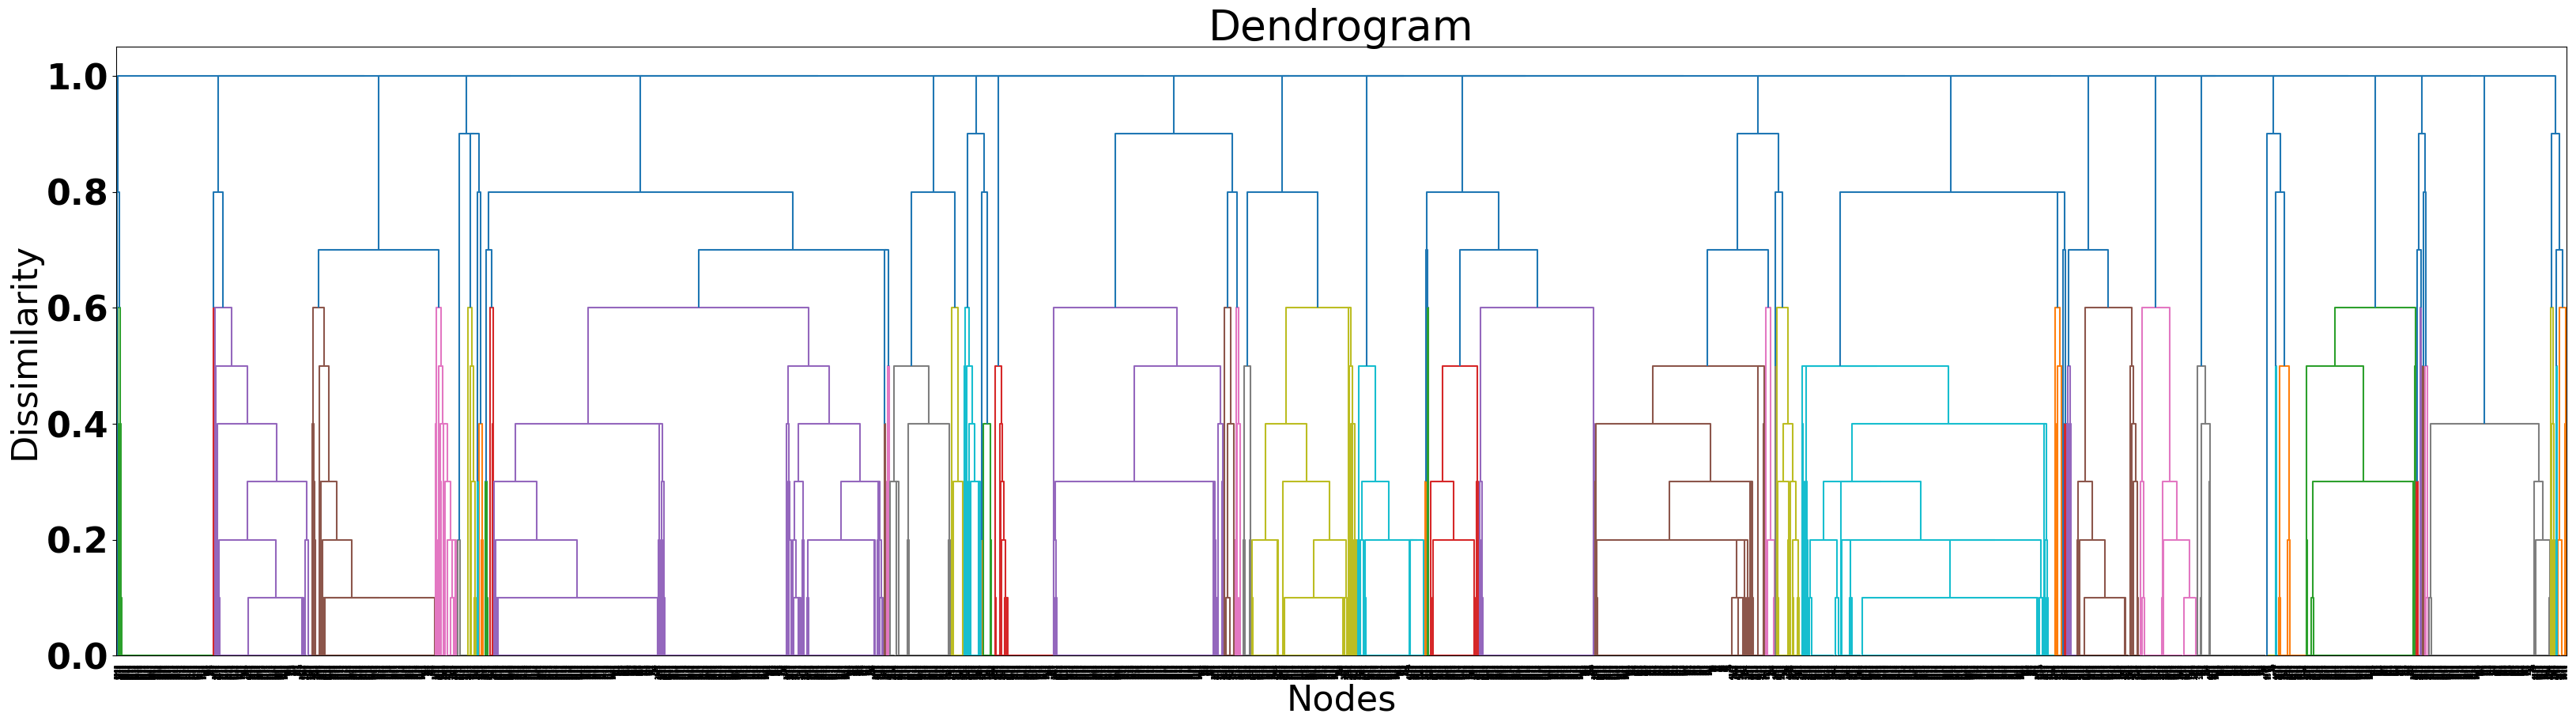

In [190]:
import scipy.cluster.hierarchy as sch
fig = plt.figure(figsize=(40, 10))
dendrogram = sch.dendrogram(sch.linkage(condensed_dist, method = 'complete')) # finding the optimal number of clusters using dendrogram
plt.title('Dendrogram') # title of the dendrogram
plt.xlabel('Nodes') # label of the x-axis
plt.ylabel('Dissimilarity') # label of the y-axis
plt.show() # show the dendrogram

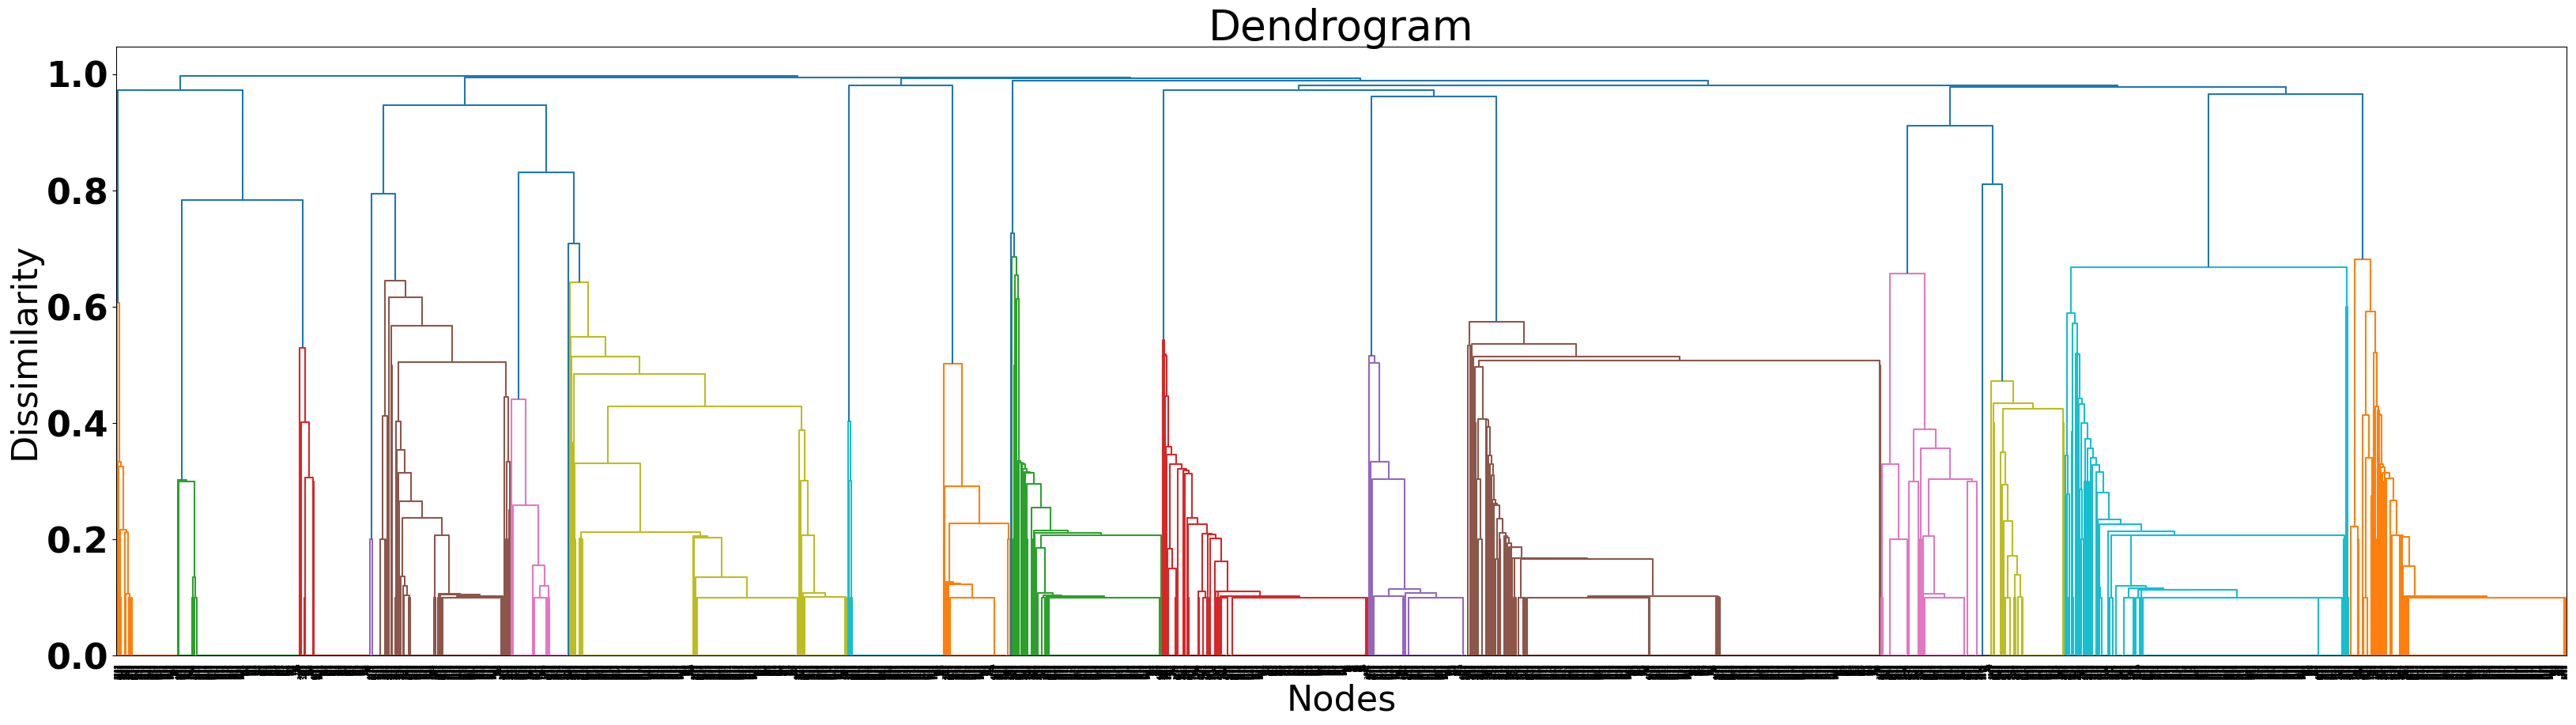

In [191]:
fig = plt.figure(figsize=(40, 10))
dendrogram = sch.dendrogram(sch.linkage(condensed_dist, method = 'average')) # finding the optimal number of clusters using dendrogram
plt.title('Dendrogram') # title of the dendrogram
plt.xlabel('Nodes') # label of the x-axis
plt.ylabel('Dissimilarity') # label of the y-axis
plt.show() # show the dendrogram

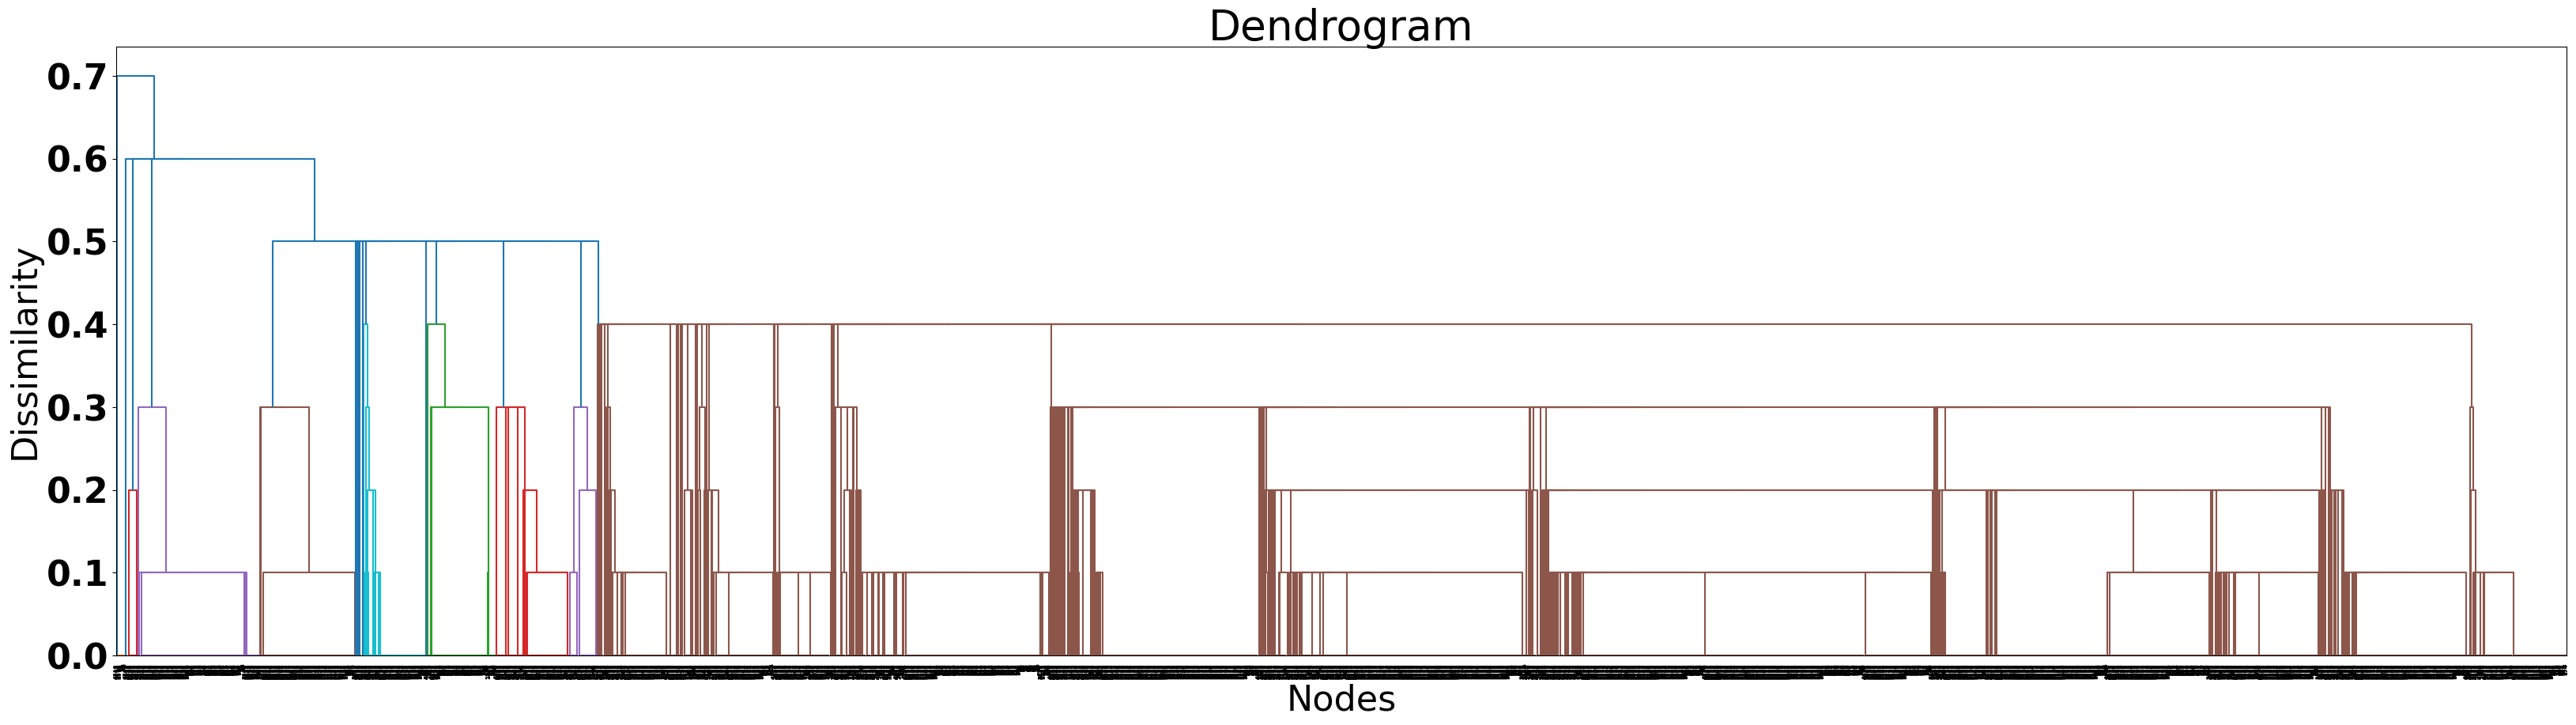

In [192]:
fig = plt.figure(figsize=(40, 10))
dendrogram = sch.dendrogram(sch.linkage(condensed_dist, method = 'single')) # finding the optimal number of clusters using dendrogram
plt.title('Dendrogram') # title of the dendrogram
plt.xlabel('Nodes') # label of the x-axis
plt.ylabel('Dissimilarity') # label of the y-axis
plt.show() # show the dendrogram

As seen in the dendrograms, hierarchical with "single" method gives bad result so we will use "complete" and average method to compute the clusters.

We find clusters of numbers in the range from the min to the max of original partitions

In [193]:
F=G.copy()
F=nx.relabel_nodes(F,node_to_num)

In [194]:
from sklearn.cluster import AgglomerativeClustering

In [195]:
lnes=[*map(len,akt2.partitions)]

In [196]:
hier_parts_complete=[]
hier_parts_avg=[]
for i in range(min(lnes),max(lnes)+1):
    c_mod=AgglomerativeClustering(n_clusters = i, affinity="precomputed",linkage="complete")
    hh=c_mod.fit_predict(dist_mat)
    hier_parts_complete.append(hh)
    c_moda=AgglomerativeClustering(n_clusters = i, affinity="precomputed",linkage="average")
    hha=c_moda.fit_predict(dist_mat)
    hier_parts_avg.append(hha)

Collecting the labels into communities

In [197]:
nodesF=np.array(list(F.nodes))
def part_collector(hier):
    m=max(hier)
    coll=[set(nodesF[hier==i].tolist()) for i in range(m+1)]
    return coll

In [198]:
fpartC=[*map(part_collector,hier_parts_complete)]
fpartA=[*map(part_collector,hier_parts_avg)]

In [199]:
C_mod=np.zeros(max(lnes)+1-min(lnes))
A_mod=np.zeros(max(lnes)+1-min(lnes))
for i,part in enumerate(fpartC):
    modul=nx_comm.modularity(F,part)
    C_mod[i]=(modul)

In [200]:
for i,part in enumerate(fpartA):
    modul=nx_comm.modularity(F,part)
    A_mod[i]=(modul)

In [201]:
print(A_mod.max())
idxA=np.where(A_mod==A_mod.max())[0][0]

0.6796802540971084


In [202]:
idxA

4

In [203]:
print(C_mod.max())
idxC=np.where(C_mod==C_mod.max())[0][0]
idxC

0.6739881106805289


5

In [204]:
C_mod

array([0.62166604, 0.63219567, 0.64372025, 0.6460781 , 0.67339788,
       0.67398811])

Choose the partition with max modularity and use it for `ypk1_num`

In [362]:
intr=fpartA[idxA].copy()

In [206]:
[*map(len,intr)]

[285,
 410,
 192,
 526,
 540,
 783,
 248,
 128,
 391,
 116,
 133,
 186,
 140,
 181,
 107,
 17,
 19,
 231,
 1,
 5]

In [332]:
homo_idx=node_to_num['4932.YKL126W']

In [363]:
ypk1_num=Network(F,homologue=homo_idx,partitions=[intr])

In [364]:
ypk1_num.homologue_index

[4]

In [365]:
im_nodes=ypk1_num.get_important_nodes()
{num_to_node[key]:im_nodes[key] for key in im_nodes}

{'4932.YHR030C': {'times_occurred': 1, 'distance': 3},
 '4932.YLR362W': {'times_occurred': 1, 'distance': 3},
 '4932.YJR066W': {'times_occurred': 1, 'distance': 2},
 '4932.YDR477W': {'times_occurred': 1, 'distance': 3},
 '4932.YGR040W': {'times_occurred': 1, 'distance': 4},
 '4932.YLR113W': {'times_occurred': 1, 'distance': 3},
 '4932.YHL007C': {'times_occurred': 1, 'distance': 3},
 '4932.YMR307W': {'times_occurred': 1, 'distance': 3},
 '4932.YBL016W': {'times_occurred': 1, 'distance': 4},
 '4932.YLR433C': {'times_occurred': 1, 'distance': 3}}

4932.YMR186W

4932.YJR066W

4932.YDL022W

4932.YJL095W
4932.YGL167C


In [366]:
len(ypk1_num.partitions[0])

20

Now for neighbouring communities

In [367]:
ypk1_num.find_neighbours()
ypk1_num.set_neighbour_communities()

In [368]:
ypk1_num.set_c_nodes_neighbour()

In [369]:
k=[*ypk1_num.central_nodes_neighbour[0]].copy()

In [370]:
k

[[2496, 1521, 1523, 1654, 2652],
 [1278, 697, 1338, 1198],
 [2607, 2614, 2394, 2396, 2622],
 [197, 327, 1195, 316, 892],
 [2050, 1854, 95],
 [1696, 1794, 1196, 945, 1941],
 [3616, 966, 2543, 1883, 1020],
 [96, 293, 46, 61, 286],
 [3264, 1410, 2949, 426, 2188],
 [960, 425, 137, 361, 588, 498],
 [2083, 2115, 202, 110, 2106, 2141],
 [2433, 4066, 3371, 4046, 1840, 1817],
 [3873, 3876, 3750, 3950, 4058],
 [2659, 1876, 2109, 2246],
 [0, 2, 3714, 13, 17, 2872],
 [4128, 3787, 4198, 3975],
 [581, 140, 749, 562, 309, 315],
 [],
 [4257, 4482, 3300, 4447]]

True

In [215]:
n_im=[[num_to_node[x] for x in y] for y in k]

In [216]:
n_im

[['4932.YMR125W',
  '4932.YBR169C',
  '4932.YPL106C',
  '4932.YDL160C',
  '4932.YPL178W'],
 ['4932.YDR388W', '4932.YML001W', '4932.YAL030W', '4932.YOR089C'],
 ['4932.YMR304C-A',
  '4932.YJR146W',
  '4932.YPR089W',
  '4932.YOL048C',
  '4932.YPR197C'],
 ['4932.YBR010W',
  '4932.YMR190C',
  '4932.YOL012C',
  '4932.YER095W',
  '4932.YML032C'],
 ['4932.YMR250W', '4932.YMR105C', '4932.YGR088W'],
 ['4932.YBR170C',
  '4932.YDR483W',
  '4932.YDL190C',
  '4932.YOL013C',
  '4932.YAL023C'],
 ['4932.YLR364W',
  '4932.YER145C',
  '4932.YPL059W',
  '4932.YGL071W',
  '4932.YMR058W'],
 ['4932.YJR121W',
  '4932.YOR065W',
  '4932.YGL226W',
  '4932.YEL024W',
  '4932.YGR183C'],
 ['4932.YLR287C',
  '4932.YML014W',
  '4932.YBL024W',
  '4932.YDL201W',
  '4932.YOR154W'],
 ['4932.YLL013C',
  '4932.YGR220C',
  '4932.YPL013C',
  '4932.YDR036C',
  '4932.YBR146W',
  '4932.YKL194C'],
 ['4932.YKR089C',
  '4932.YMR165C',
  '4932.YER015W',
  '4932.YGL205W',
  '4932.YOR081C',
  '4932.YOL147C'],
 ['4932.YGL013C',
  '4932

In [360]:
p=fpartA[idxA].copy()
labelled_p={i:part for i,part in enumerate(p)}
node_dictx={node:i  for i in labelled_p for node in labelled_p[i]}

In [361]:
len(node_dictx)

4639

In [219]:
len(list(F.nodes))

4639

In [329]:
def part_graph_2(G_1, partition):
    N = len(partition) # Number of communities 
    labelled_partition={i:part for i,part in enumerate(partition)}
    node_dict={node:i  for i in labelled_partition for node in labelled_partition[i]}
    G = nx.Graph()
    for i in range (N): 
        G.add_node(i)

    nodes=[*G_1.nodes]


    intra_comm_combs=map(lambda x: combinations(x,2),partition)
    intra_comm_2=[*map(list,intra_comm_combs)]
    intra_comm_3=sum(intra_comm_2,[])
    
    intra_comm_edges={*map(frozenset,intra_comm_3)}
    all_edges={*map(frozenset,G_1.edges)}

    inter_comm_edges=all_edges-intra_comm_edges
    
    inter_comm_tuple=map(tuple,inter_comm_edges)

    inter_edges=map(lambda x:frozenset((node_dict[x[0]],node_dict[x[1]])),inter_comm_tuple)

    edge_weights=Counter(inter_edges)

    w={e:edge_weights[e]/100 for e in edge_weights}

    for t in edge_weights:
        a,b=t
        G.add_edge(a, b, weight = edge_weights[t])

    return G

In [330]:
G2=part_graph_2(F, p)

In [222]:
node_remove=[i for i,p in enumerate(p) if len(p)<=10]

In [223]:
node_remove

[18, 19]

In [224]:
G2.remove_nodes_from(node_remove)

In [225]:
G2.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17))

In [226]:
l=nx.laplacian_matrix(G2).toarray()

<class 'networkx.utils.decorators.argmap'> compilation 37:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [288]:
eig=nx.laplacian_spectrum(G2)

<class 'networkx.utils.decorators.argmap'> compilation 37:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [289]:
eig

array([7.99360577e-15, 7.28188532e-02, 9.53394073e-02, 2.43898827e-01,
       2.76979467e-01, 1.69931360e+00, 3.19947079e+00, 3.53048936e+00,
       3.71838873e+00, 4.24223218e+00, 6.66308391e+00, 8.26928437e+00,
       1.02412062e+01, 1.23330274e+01, 1.41909545e+01, 1.56117501e+01,
       1.67650462e+01, 2.14069694e+01, 3.32284795e+01, 6.06912671e+01])

In [290]:
x=np.arange(eig.shape[0])+1

In [291]:
x

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

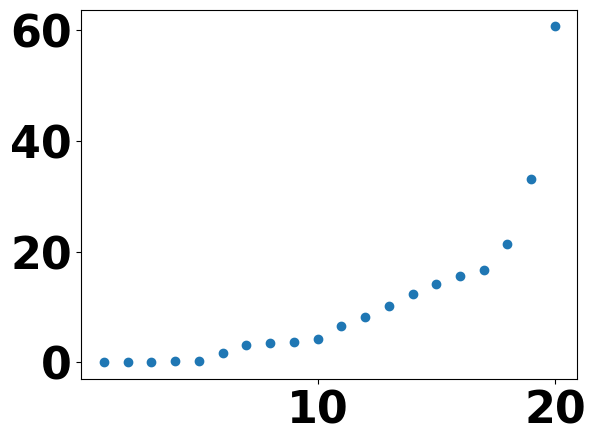

In [292]:
plt.scatter(x,eig)

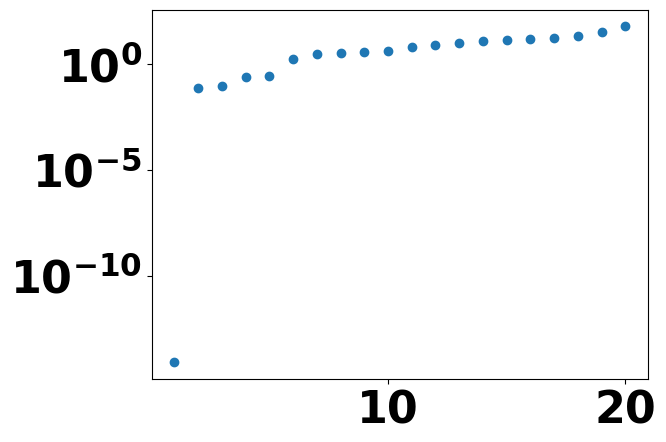

In [293]:
plt.scatter(x,eig)
plt.yscale('log')

In [233]:
eig

array([-3.17230334e-13,  2.43854909e+01,  2.75491149e+01,  1.69869003e+02,
        3.19921932e+02,  3.52993477e+02,  3.71790315e+02,  4.23945142e+02,
        6.65561063e+02,  8.26327999e+02,  1.02239691e+03,  1.23234617e+03,
        1.41828832e+03,  1.55938563e+03,  1.67483211e+03,  2.13822873e+03,
        3.31990950e+03,  6.06826910e+03])

We have a spectral gap after the first eight eigenvalues, so $k=8$ for spectral clustering.

In [294]:
def spectral_cluster(G,k=4):
    #Find the graph laplacian
    lap=nx.laplacian_matrix(G).toarray()
    #Find the eigenvalues and eigenvectors and order them from the smallest to the largest
    #The eigenvalues and eigenvectors are supposed to be real so we discard any possible imaginary parts
    evals,evec=LA.eig(lap)
    evals=evals[np.argsort(evals)].real
    evec=evec[:,np.argsort(evals)].real
    #Use the first k eigenvectors to do the k-means clustering
    pts=evec[:,0:k]
    kmeans = KMeans(n_clusters=k) 
    kmeans.fit(pts)
    return kmeans.labels_

In [295]:
part_spectral=spectral_cluster(G2)

c:\Users\lihao\.conda\envs\new_py\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [296]:
part_spectral

array([0, 0, 0, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [237]:
def spectral_cluster_rw(G,k=4):
    #Find the adjacency mtx and hence the random walk mtx
    A=nx.adjacency_matrix(G).toarray()
    D = np.diag(A.sum(axis=1))
    rw=A@LA.inv(D)
    #Find the eigenvalues and eigenvectors and order them from the smallest to the largest
    #The eigenvalues and eigenvectors are supposed to be real so we discard any possible imaginary parts
    evals,evec=LA.eig(rw)
    evals=evals[np.argsort(evals)].real
    #print(evals)
    evec=evec[:,np.argsort(evals)].real
    #Use the first k eigenvectors to do the k-means clustering
    pts=evec[:,0:k]
    #print(pts)
    kmeans = KMeans(n_clusters=k) 
    kmeans.fit(pts)
    return kmeans.labels_

In [238]:
spectral_cluster_rw(G2,k=8)

C:\Users\lihao\AppData\Local\Temp\ipykernel_14476\4103987050.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A=nx.adjacency_matrix(G).toarray()
c:\Users\lihao\.conda\envs\new_py\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([7, 7, 0, 4, 6, 3, 0, 0, 5, 0, 2, 0, 0, 0, 7, 0, 0, 1])

In [239]:
[*nx_comm.louvain_partitions(G2,resolution=2)]

[[{0}, {2, 12, 13}, {3, 4, 14}, {5, 7, 8, 11}, {1, 6, 16}, {15}, {9, 10, 17}]]

$k$-means is not useful as our target community is on its own.

In [283]:
threshold_score = 10
for edge in G2.edges: 
    weight = list(G2.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G2.remove_edge(edge[0],edge[1])

In [251]:
len([*G2.edges])

45

{0: Text(0.24121536573134408, -0.09389951796602605, '0'),
 1: Text(0.13184664626668835, -0.6735973973506341, '1'),
 2: Text(-0.04149861111429541, -0.04516062611076391, '2'),
 3: Text(0.6679540064901855, 0.24073571260320267, '3'),
 4: Text(0.12173314095604727, 0.6929375638144782, '4'),
 5: Text(-1.0, 0.7549819447981754, '5'),
 6: Text(0.38903332294317194, -0.14331697667879262, '6'),
 7: Text(0.4164772762018715, 0.16033891071945927, '7'),
 8: Text(-0.3429930069156421, 0.20151449487094777, '8'),
 9: Text(-0.0022161053042868057, -0.2670980790807379, '9'),
 10: Text(-0.24548993009623962, -0.23690293236424115, '10'),
 11: Text(-0.17951255327449542, -0.4685704500050081, '11'),
 12: Text(0.11854911265064319, 0.16796308563434742, '12'),
 13: Text(-0.21678286843719038, 0.4726022292303692, '13'),
 14: Text(0.35654330305048293, -0.3626852244421212, '14'),
 15: Text(-0.001285973055202389, -0.022276524595211327, '15'),
 16: Text(0.0065491338694123455, -0.02117713200326422, '16'),
 17: Text(-0.460593

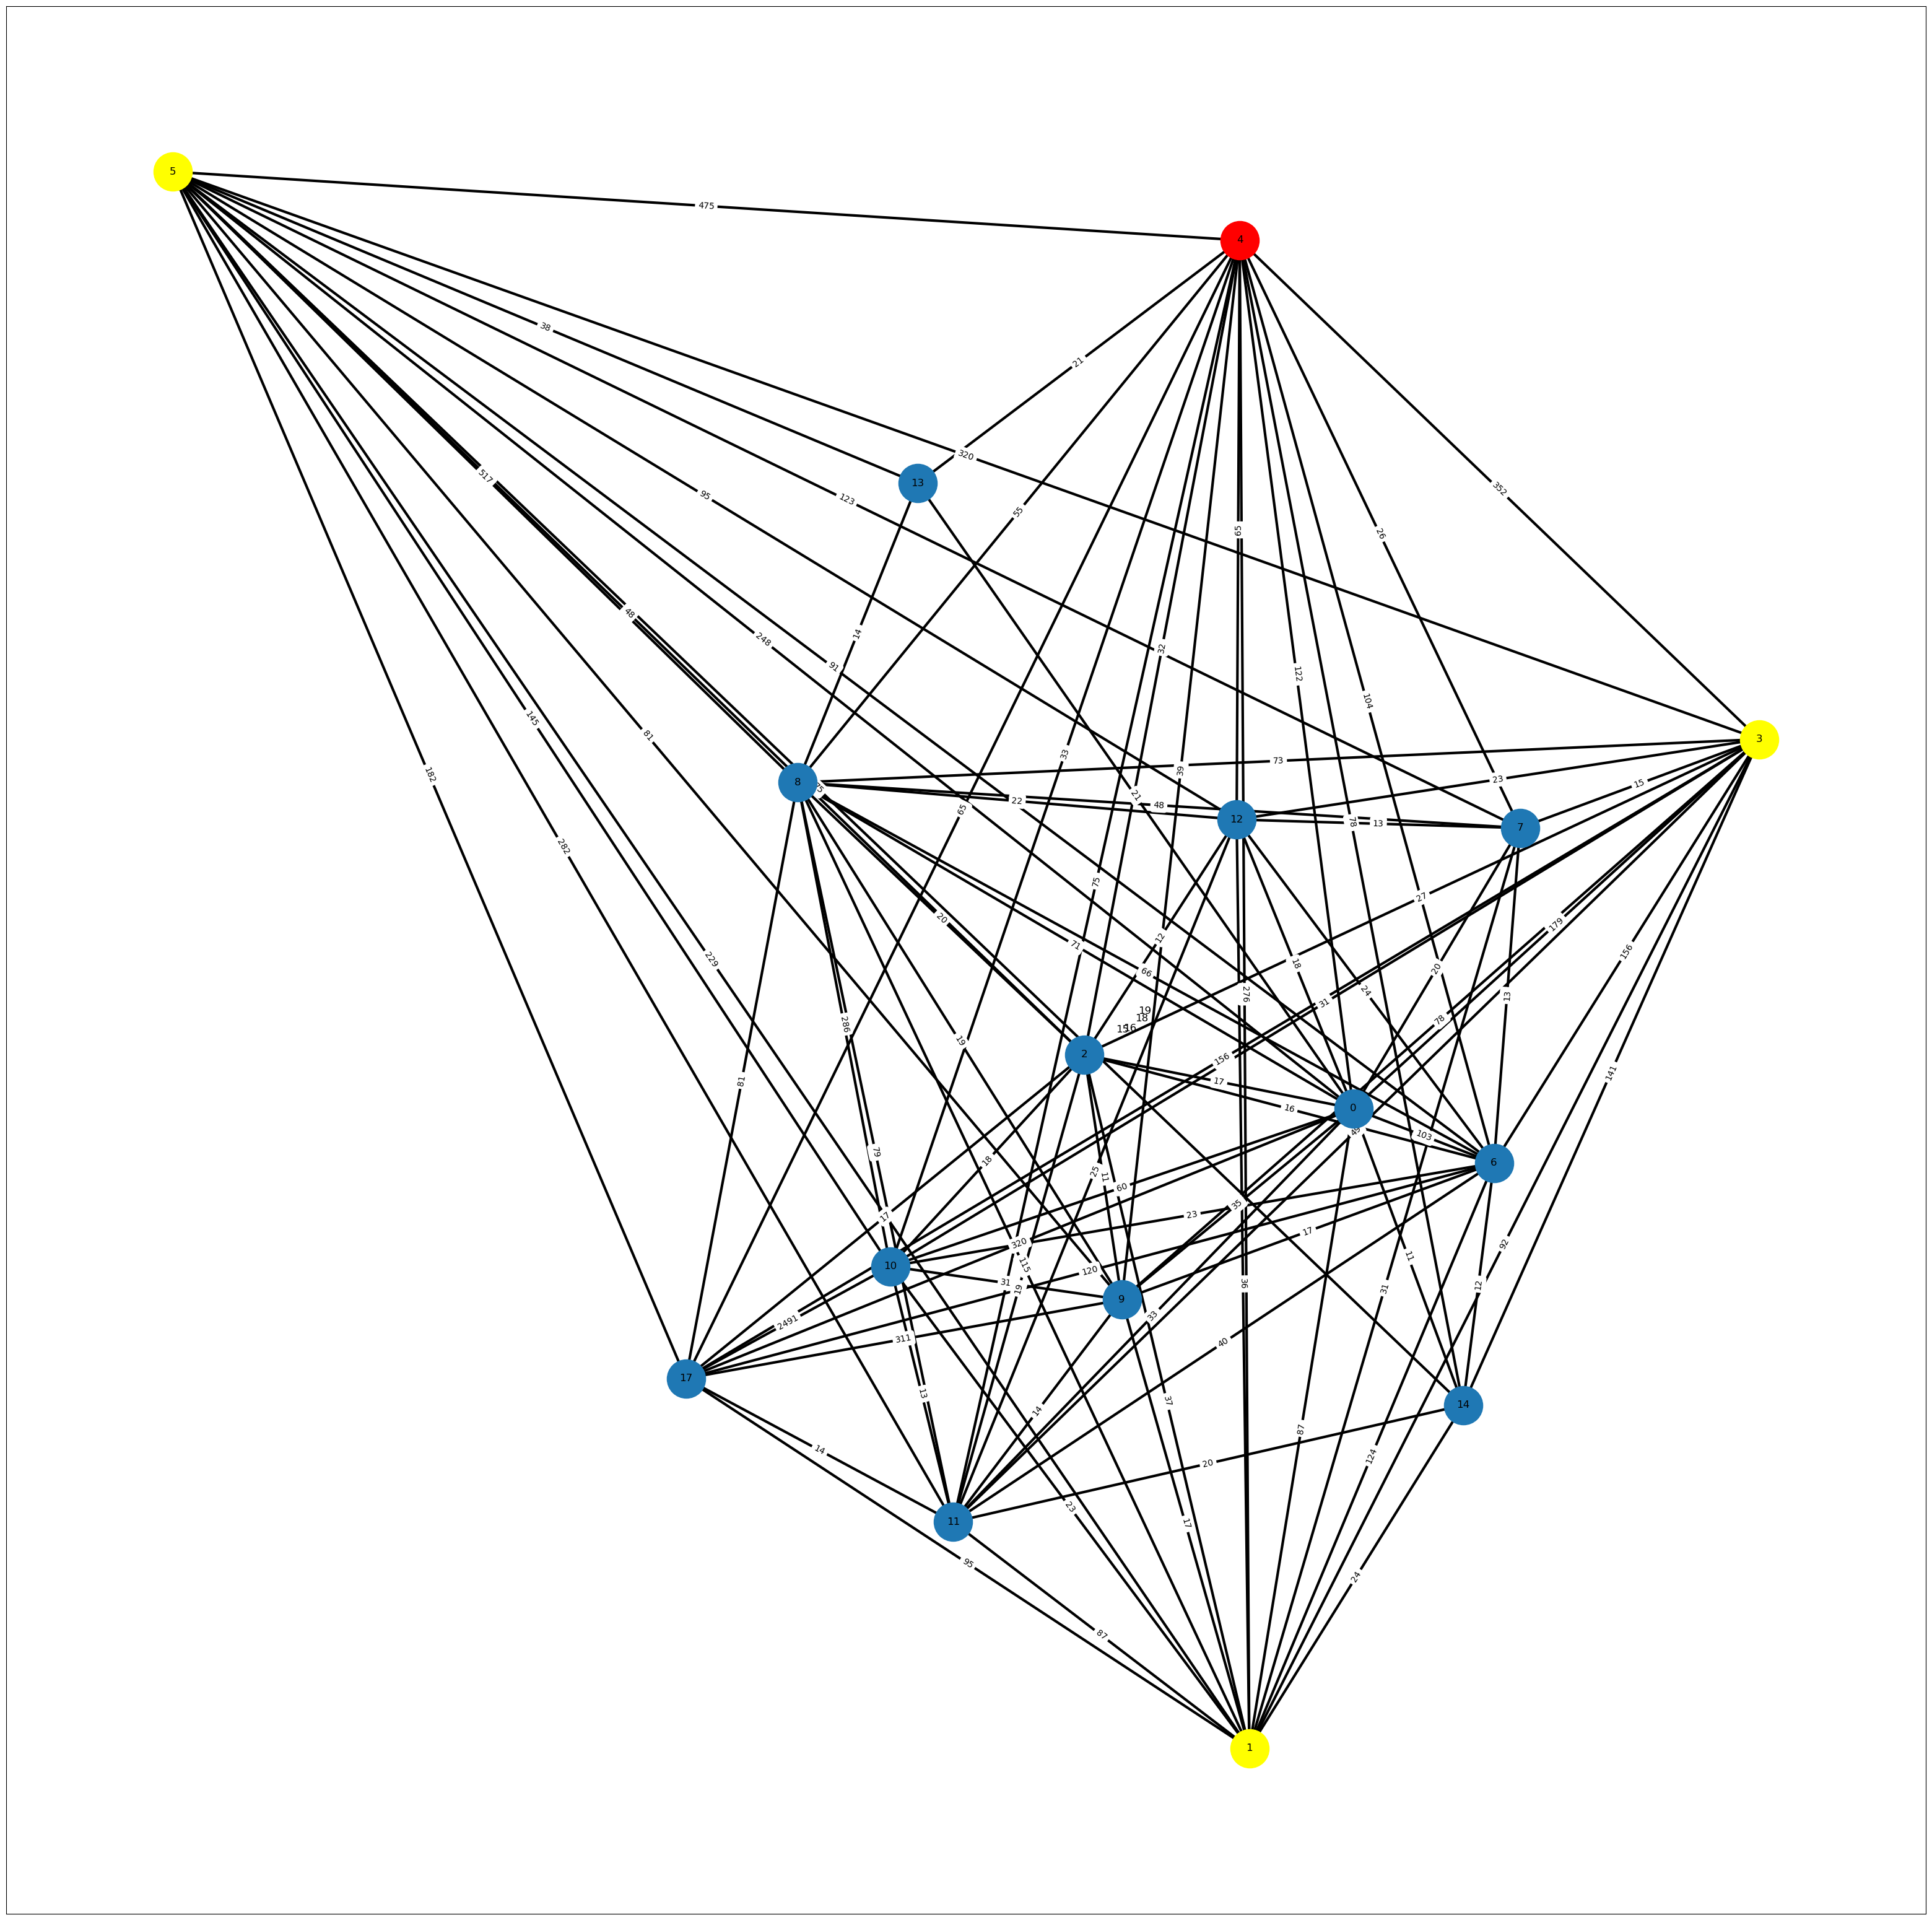

In [285]:
threshold = 200
def draw_neighbours(G2, pos, neighbours):
    for n in neighbours:
        colour = '#ffff00' if G2[4][n]['weight'] > threshold else "#1f78b4"
        nx.draw_networkx_nodes(G2, pos, nodelist=[n], node_size=2000, node_color=colour)

edge_labels = nx.get_edge_attributes(G2, "weight")
fig = plt.figure(figsize=(40, 40))

neighbours = list(G2.neighbors(4)) # the communities adjacent to ours

pos = nx.kamada_kawai_layout(G2)

nx.draw_networkx_nodes(G2, pos, nodelist=[4], node_size=2000, node_color='#ff0000')
draw_neighbours(G2, pos, neighbours)
nx.draw_networkx_edges(G2, pos, width=3)
nx.draw_networkx_edge_labels(G2, pos, edge_labels)
nx.draw_networkx_labels(G2, pos)



In [253]:
G2[4]

AtlasView({1: {'weight': 276}, 5: {'weight': 475}, 14: {'weight': 78}, 17: {'weight': 65}, 6: {'weight': 104}, 12: {'weight': 65}, 3: {'weight': 352}, 8: {'weight': 55}, 11: {'weight': 75}, 0: {'weight': 122}})

In [320]:
k[1]

[1278, 697, 1338, 1198]

In [256]:
k[3]

[197, 327, 1195, 316, 892]

In [257]:
k[4]

[2050, 1854, 95]

In [371]:
kk=k[1]+k[3]+k[4]+k[0]+k[5]

In [372]:
all_nodes=[]
for n in kk:
    s_p= nx.all_shortest_paths(F,homo_idx,n)
    s_nodes=[]
    for p in s_p:
        p=p[1:-1]
        s_nodes+=p
    all_nodes+=[*s_nodes]


In [373]:
sorted(Counter(all_nodes).items(), key=lambda x:x[1],reverse=True)


[(952, 46),
 (108, 25),
 (532, 24),
 (1193, 18),
 (1267, 17),
 (1081, 12),
 (989, 10),
 (1723, 9),
 (1951, 9),
 (486, 9),
 (2482, 7),
 (2779, 7),
 (1801, 7),
 (1926, 7),
 (2022, 6),
 (949, 6),
 (197, 6),
 (1483, 6),
 (1419, 5),
 (689, 5),
 (802, 5),
 (1941, 5),
 (686, 4),
 (1240, 4),
 (2229, 4),
 (2827, 4),
 (937, 4),
 (1195, 4),
 (523, 4),
 (1229, 4),
 (2864, 4),
 (1716, 4),
 (1471, 4),
 (1183, 4),
 (1948, 4),
 (3053, 4),
 (1239, 4),
 (2859, 3),
 (2755, 3),
 (1919, 3),
 (1846, 3),
 (1661, 3),
 (1057, 3),
 (1797, 3),
 (1628, 3),
 (32, 3),
 (4398, 3),
 (3193, 3),
 (1241, 2),
 (735, 2),
 (2547, 2),
 (1311, 2),
 (1278, 2),
 (3029, 2),
 (718, 2),
 (910, 2),
 (608, 2),
 (606, 2),
 (2996, 2),
 (280, 2),
 (316, 2),
 (880, 2),
 (878, 2),
 (614, 2),
 (1967, 2),
 (1946, 2),
 (1865, 2),
 (1852, 2),
 (1854, 2),
 (1835, 2),
 (1810, 2),
 (2057, 2),
 (1085, 2),
 (1521, 2),
 (2110, 2),
 (1849, 2),
 (2909, 2),
 (212, 2),
 (992, 2),
 (940, 2),
 (2532, 2),
 (1545, 2),
 (1531, 2),
 (1567, 2),
 (1000, 2),


In [353]:
for i in [952,108,532,1193,1267]:
    print(num_to_node[i])

4932.YMR186W
4932.YJR066W
4932.YDL022W
4932.YJL095W
4932.YGL167C


In [270]:
[*nx.all_shortest_paths(F,homo_idx,2050)][0][1:-1]

[532, 523]

In [243]:
deg=nx.degree_centrality(G2)
bet=nx.betweenness_centrality(G2)

In [244]:
deg

{0: 0.6470588235294118,
 1: 0.7647058823529411,
 2: 0.23529411764705882,
 3: 0.7647058823529411,
 4: 0.8823529411764706,
 5: 0.8823529411764706,
 6: 0.5882352941176471,
 7: 0.23529411764705882,
 8: 0.6470588235294118,
 9: 0.3529411764705882,
 10: 0.5294117647058824,
 11: 0.47058823529411764,
 12: 0.4117647058823529,
 13: 0.1764705882352941,
 14: 0.23529411764705882,
 15: 0.0,
 16: 0.0,
 17: 0.5294117647058824}

In [245]:
bet

{0: 0.027223389355742297,
 1: 0.050945378151260504,
 2: 0.0,
 3: 0.04604341736694677,
 4: 0.1018032212885154,
 5: 0.1018032212885154,
 6: 0.0056022408963585435,
 7: 0.0,
 8: 0.018469887955182073,
 9: 0.0,
 10: 0.003676470588235294,
 11: 0.0010504201680672268,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.003676470588235294}

In [246]:
d=np.array([*deg.values()])

In [247]:
b=np.array([*bet.values()])

In [248]:
d

array([0.64705882, 0.76470588, 0.23529412, 0.76470588, 0.88235294,
       0.88235294, 0.58823529, 0.23529412, 0.64705882, 0.35294118,
       0.52941176, 0.47058824, 0.41176471, 0.17647059, 0.23529412,
       0.        , 0.        , 0.52941176])

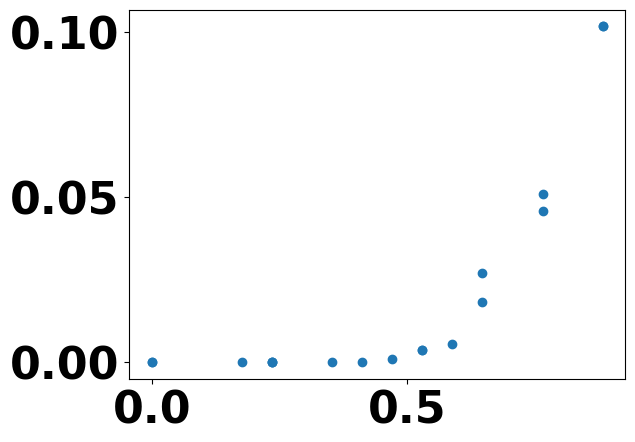

In [249]:
plt.scatter(d,b)

In [374]:
[num_to_node[i] for i in k[1]]

['4932.YDR388W', '4932.YML001W', '4932.YAL030W', '4932.YOR089C']

In [375]:
[num_to_node[i] for i in k[3]]

['4932.YBR010W',
 '4932.YMR190C',
 '4932.YOL012C',
 '4932.YER095W',
 '4932.YML032C']

In [376]:
[num_to_node[i] for i in k[4]]

['4932.YMR250W', '4932.YMR105C', '4932.YGR088W']